In [1]:
import numpy as np
import itertools
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt


# Start with Digits Dataset from Sklean

In [2]:
# Start by loading the digits datset
digits = load_digits()
digits_data = digits.data     # the 64-dim digits images
digit_label = digits.target  # the label into one of 10 clusters: 0,1,...,9

n_digits = np.unique(digit_label).shape[0]

# turn the ground-truth labels into a clusim Clustering
true_clustering = Clustering().from_membership_list(digit_label) 

# Note: a membership list treats each index as a data element and assigns 
# the cluster label as the value of the list at the index 



In [3]:
# a helper function to draw digits dataset

def get_color_map(cmap = 'viridis', vmin = 0, vmax = 1):
    plt_cmap = plt.get_cmap(cmap)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    scalarMap = mpl.cm.ScalarMappable(norm=norm, cmap=plt_cmap)
    return scalarMap

def plot_digits(X, clustering, digit, ax = None, fontsize = 9, 
    cmap = 'magma', colorbar=False, title=None, vmin = 0, vmax = 1):
    
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    
    if ax is None:
        plt.figure()
        ax = plt.subplot(111)
    
    ax.axis('off')

    if type(cmap) == dict:
        color_func = lambda c: cmap[c]

    else:
        scalarMap = get_color_map(cmap, vmin, vmax)
        color_func = lambda c: scalarMap.to_rgba(c)
        if colorbar:
            scalarMap.set_array(np.linspace(vmin,vmax,10))
            plt.colorbar(scalarMap, orientation='vertical', ax=ax)
    
    if isinstance(clustering, Clustering):
        point_value = clustering.to_membership_list()
    else:
        point_value = clustering
    
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], str(digit[i]),
                 color = color_func(point_value[i]),
                 fontdict={'weight': 'bold', 'size': fontsize})
        
    return ax

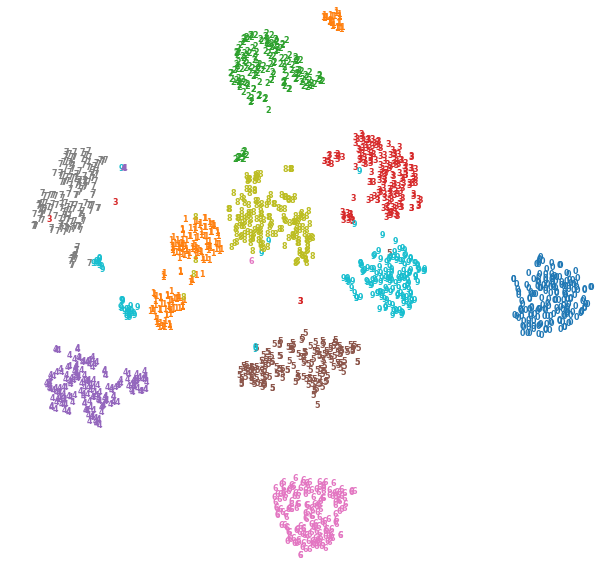

In [4]:

# lets get a 2-D embedding using TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(digits_data)


# using the above function, we can draw a pretty picture
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax = plot_digits(X_tsne, true_clustering, digit_label, ax = ax, 
               cmap = 'tab10', vmin = 0, vmax = 10, fontsize = 8)

plt.show()

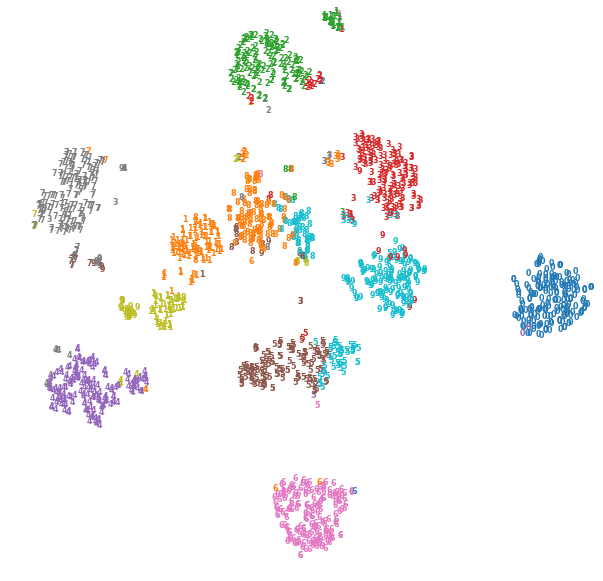

In [5]:
# now lets run k-means on the orginal data
kmeans_estimator = KMeans(init='random', n_clusters=n_digits, n_init=10)
kmeans_estimator.fit(digits_data)

kmeans_labels = kmeans_estimator.predict(digits_data)
kmeans_clustering = Clustering().from_membership_list(kmeans_labels) 

# re-draw the picture
fig, ax = plt.subplots(1,1,figsize=(10,10))

# the k-means algorithm randomly uses the cluster labels 0,1,...,9
# so lets remap them to have the closest overlap we can with the
# original digit labels - basically just to make the colors align between our pictures
kmeans_clustering.relabel_clusters_to_match(true_clustering)

# color now corresponds to the predicted cluster
ax = plot_digits(X_tsne, kmeans_clustering, 
                 digit_label, ax = ax, 
               cmap = 'tab10', vmin = 0, vmax = 10, fontsize = 8)

plt.show()

# Clustering Similarity

In [6]:
# lets see how similar the predicted k-means clustering is to the true clustering

# using all available similar measures!
row_format2 ="{:>25}" * (2)
for simfunc in sim.available_similarity_measures:
    print(row_format2.format(simfunc, eval('sim.' + simfunc+'(true_clustering, kmeans_clustering)')))

            jaccard_index       0.5333914567850583
               rand_index       0.9379806482717422
            adjrand_index       0.6611943827641403
    fowlkes_mallows_index       0.6958923090694253
                 fmeasure       0.6957016154288199
             purity_index       0.7874234835837507
     classification_error       0.2125765164162493
        czekanowski_index       0.6957016154288199
               dice_index       0.6957016154288199
           sorensen_index       0.6957016154288199
    rogers_tanimoto_index       0.8832048556792647
          southwood_index        1.143124069503702
      pearson_correlation    2.776059837648866e-12
         corrected_chance       0.5069367290775231
      sample_expected_sim     0.052922909463439624
                      nmi        0.739364913850611
                       mi       2.4420048504193232
                   adj_mi       0.7367399782089021
                      rmi         2.23156656591647
                       vi      

# Element-centric Similarity

In [7]:
# The element-centric similarity is particularly useful for understanding
# how a clustering method performed

# Let's start with the single similarity value:
elsim = sim.element_sim(true_clustering, kmeans_clustering)
print("Element-centric similarity: {}".format(elsim))

Element-centric similarity: 0.671210685776866


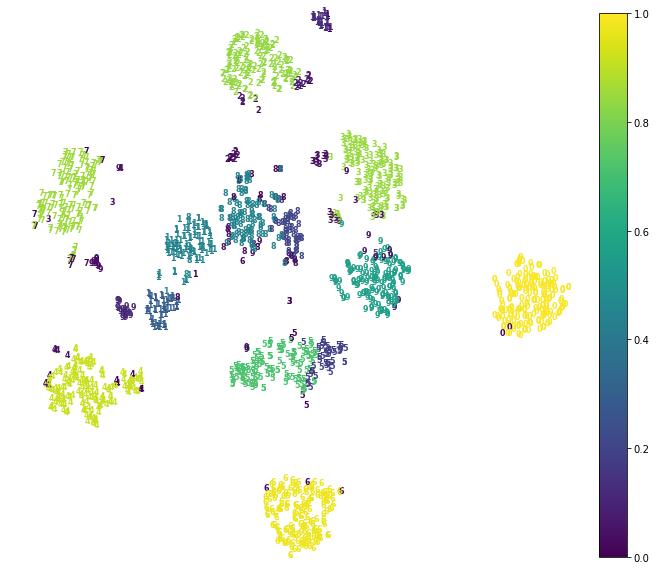

In [8]:
# The real advantages of the element-centric perspective come with understanding  
# which data-points are contributing to the differences

elementScores, relabeled_elements = sim.element_sim_elscore(true_clustering, kmeans_clustering)
# elementScores gives a similarity value for each element (datapoint, node, etc.)

# relabeled_elements is a dict that maps elements to indexes of elementScore 
# --- this is important if your elements are not consisently named named 0,1,2, ..., n_elements-1
# as when you took a subset of the data and did not rename, or your elements are strings

# re-draw the picture
fig, ax = plt.subplots(1,1,figsize=(12,10))

# color now corresponds to the element-wise clustering similarity
# yellow is nearly perfect cluster assignment, 
# while purple denotes elements that are assigned to different clusters
#
# Note that the whole cluster changes color when a few elements are mis-assigned
# since it has changed that cluster 
ax = plot_digits(X_tsne, elementScores, 
                 digit_label, ax = ax, colorbar=True,
               cmap = 'viridis', vmin = 0, vmax = 1, fontsize = 8) # max similarity is now 1
plt.show()

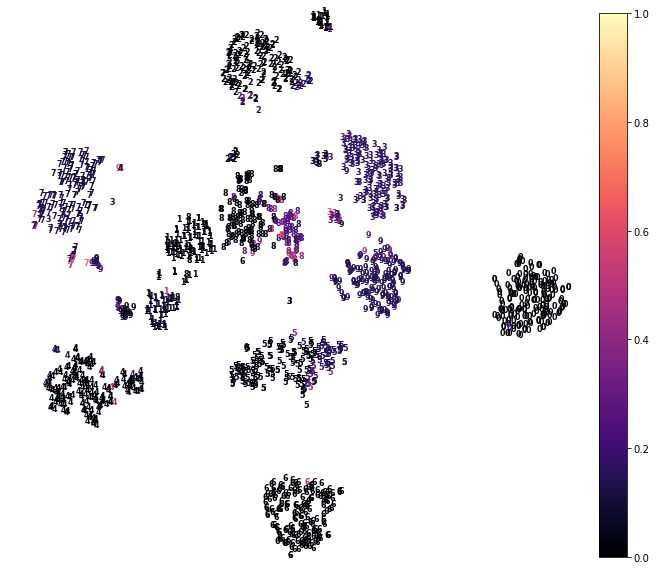

In [9]:
# We can also explore the clustering method's frustration.

# K-means is technically a stochastic algorithm (it can give you a different result
# based on the initial centroid locations) so lets explore how different 
# initializations produce different solutions 

# lets run K-means 10 times
n_samples = 10
kmeans_clustering_list=[]
kmeans_estimator = KMeans(init='random', n_clusters=n_digits, n_init=10)
for isample in range(n_samples):
    kmeans_labels = kmeans_estimator.fit_predict(digits_data)
    kmeans_clustering_list.append(Clustering().from_membership_list(kmeans_labels) )


# now we find the average elementScores when comparing each pair of 
# k-means clusterings
kmeans_frustration = np.zeros(digits_data.shape[0])
for isample, jsample in itertools.combinations(range(n_samples), 2):
    elementScores, relabeled_elements = sim.element_sim_elscore(kmeans_clustering_list[isample], 
                                                                kmeans_clustering_list[jsample])
    kmeans_frustration += elementScores

kmeans_frustration = 1.0 - kmeans_frustration / (n_samples * (n_samples-1) / 2)



# re-draw the picture
fig, ax = plt.subplots(1,1,figsize=(12,10))

# color now corresponds to the element-wise clustering frustration
# black elements are consistently placed into the same cluster
# while yellow denotes elements that are assigned to different clusters every time you run k-means
#
# Note that the frustration is different from the similarity:
# an element can be consistently assigned to the wrong cluster
ax = plot_digits(X_tsne, kmeans_frustration, 
                 digit_label, ax = ax, colorbar=True,
               cmap = 'magma', vmin = 0, vmax = 1, fontsize = 8) # max similarity is now 1
plt.show()